In [1]:
!pip install langchain
!pip install gpt4all
!pip install chromadb
!pip install llama-cpp-python
!pip install urllib3
!pip install python-dotenv
!pip install tqdm
!pip install sentence_transformers
!pip install langchain-community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.2/310.2 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.8/29.8 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [2]:
# Standard Library Imports
import os
import glob
import time
from multiprocessing import Pool

# Third-Party Library Imports
from typing import List
from dotenv import load_dotenv
from tqdm import tqdm

# Langchain Imports
from langchain.document_loaders import (
    CSVLoader
)
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document
from langchain.chains import RetrievalQA
from langchain.llms import GPT4All, LlamaCpp
from transformers import AutoModel, AutoTokenizer  # Only import required submodules from transformers
import re
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import ast

# ChromaDB Imports
from chromadb.config import Settings
import chromadb

# Argument Parsing
import argparse

import torch  # Import PyTorch to check GPU availability

from google.colab import drive

In [3]:
persist_directory = "./db/"
model_type = "GPT4All_GPT2"
#model_type = "LLaMA_2_7B"
source_directory = "/content/drive/MyDrive/Colab/SOR/"
model_path = "/content/drive/MyDrive/Colab/Models/"
embeddings_model_name = "all-MiniLM-L6-v2"

chunk_size = 500
chunk_overlap = 50
target_source_chunks = 4

In [4]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# List files in the specified source directory
archivos = os.listdir(source_directory)

# Count the number of files in the directory
cantidad_de_archivos = len(archivos)

# Print the number of files in the directory
print(f"The folder '{source_directory}' contains {cantidad_de_archivos} files.")


The folder '/content/drive/MyDrive/Colab/SOR/' contains 4 files.


In [6]:
# Check if GPU is available and set the device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cpu


In [7]:
# Create embeddings using Hugging Face model
# The 'embeddings_model_name' specifies the pre-trained model to use for embeddings.

# Load the model and tokenizer from transformers, specifying the device
embeddings = HuggingFaceEmbeddings(model_name=embeddings_model_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [8]:
# Map file extensions to document loaders and their arguments
LOADER_MAPPING = {
    ".csv": (CSVLoader, {})
    # Add more mappings for other file extensions and loaders as needed
}


In [9]:
# Function to load a single document based on its file path
def load_single_document(file_path: str) -> List[Document]:
    # Extract the file extension from the given file path.
    ext = "." + file_path.rsplit(".", 1)[-1].lower()

    # Check if the file extension is in the LOADER_MAPPING dictionary.
    if ext in LOADER_MAPPING:
        # Get the loader class and loader arguments for the specified extension.
        loader_class, loader_args = LOADER_MAPPING[ext]

        # Create an instance of the loader class with the specified file path and arguments.
        loader = loader_class(file_path, **loader_args)

        # Load the document using the loader and return it.
        return loader.load()

    # If the file extension is not supported, raise a ValueError.
    raise ValueError(f"Unsupported file extension '{ext}'")

In [10]:
# Function to load documents from the source directory
def load_documents(source_dir: str, ignored_files: List[str] = []) -> List[Document]:
    # Find all files in the source directory with extensions specified in LOADER_MAPPING.
    all_files = []
    for ext in LOADER_MAPPING:
        all_files.extend(
            glob.glob(os.path.join(source_dir, f"**/*{ext.lower()}"), recursive=True)
        )
        all_files.extend(
            glob.glob(os.path.join(source_dir, f"**/*{ext.upper()}"), recursive=True)
        )

    # Filter out files that are in the ignored_files list.
    filtered_files = [file_path for file_path in all_files if file_path not in ignored_files]

    # Use a multiprocessing Pool to load documents in parallel.
    with Pool(processes=os.cpu_count()) as pool:
        results = []
        # Create a progress bar for loading documents.
        with tqdm(total=len(filtered_files), desc='Loading new documents', ncols=80) as pbar:
            for i, docs in enumerate(pool.imap_unordered(load_single_document, filtered_files)):
                results.extend(docs)
                pbar.update()

    return results



In [11]:
# Function to process documents into text chunks
def process_documents(ignored_files: List[str] = []) -> List[Document]:
    # Print a message indicating that documents are being loaded from the specified source directory.
    print(f"Loading documents from {source_directory}")

    # Load documents from the source directory, excluding any ignored files.
    documents = load_documents(source_directory, ignored_files)

    # Check if there are no documents to process and exit if that's the case.
    if not documents:
        print("No new documents to load")
        exit(0)

    # Print the number of loaded documents and the source directory.
    print(f"Loaded {len(documents)} new documents from {source_directory}")

    # Create a text splitter with the specified chunk size and overlap.
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)

    # Split the loaded documents into chunks of text using the text splitter.
    texts = text_splitter.split_documents(documents)

    # Print the number of text chunks created and the maximum chunk size.
    print(f"Split into {len(texts)} chunks of text (max. {chunk_size} tokens each)")

    # Return the resulting text chunks.
    return texts

In [12]:
# Function to check if the vector store already exists
def does_vectorstore_exist(persist_directory: str, embeddings: HuggingFaceEmbeddings) -> bool:
    # Create a Chroma vector store instance with the specified persist directory and embeddings.
    db = Chroma(persist_directory=persist_directory, embedding_function=embeddings)

    # Get the 'documents' data from the vector store. If it's empty, return False; otherwise, return True.
    if not db.get()['documents']:
        return False
    return True

In [13]:
# Check if the vector store already exists in the specified directory with the given embeddings.
if does_vectorstore_exist(persist_directory, embeddings):
    # If the vector store exists, append to it.
    print(f"Appending to existing vector store at {persist_directory}")

    # Create a Chroma vector store instance with the specified directory and embeddings.
    db = Chroma(persist_directory=persist_directory, embedding_function=embeddings)

    # Get the existing collection from the vector store.
    collection = db.get()

    # Extract source file paths from the collection's metadata.
    source_file_paths = [metadata['source'] for metadata in collection['metadatas']]

    # Process the documents based on the extracted source file paths.
    texts = process_documents(source_file_paths)

    # Inform the user about the embeddings creation process.
    print(f"Creating embeddings. May take some minutes...")

    # Check if 'texts' is not empty before adding documents to the vector store
    if texts:
        # Add the processed documents to the vector store.
        db.add_documents(texts)
    else:
        print("No documents to add. Skipping insertion.")
else:
    # If the vector store does not exist, create a new one.
    print("Creating a new vector store")

    # Process documents without specifying ignored files (default behavior).
    texts = process_documents()

    # Inform the user about the embeddings creation process.
    print(f"Creating embeddings. May take some minutes...")

    # Create a new Chroma vector store with the processed documents and embeddings.
    db = Chroma.from_documents(texts, embeddings, persist_directory=persist_directory)

# Persist the vector store.
db.persist()

# Clear the db variable to free up resources.
db = None

# Inform the user that the ingestion process is complete.
print(f"Ingestion complete!")


Creating a new vector store
Loading documents from /content/drive/MyDrive/Colab/SOR/


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Loading new documents: 100%|██████████████████████| 1/1 [00:00<00:00,  1.80it/s]


Loaded 297 new documents from /content/drive/MyDrive/Colab/SOR/
Split into 297 chunks of text (max. 500 tokens each)
Creating embeddings. May take some minutes...
Ingestion complete!


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  warn_deprecated(


In [14]:
# Create settings for Chroma database configuration
settings = Settings(
    persist_directory=persist_directory,  # Directory for persisting database data
    anonymized_telemetry=False  # Disable anonymized telemetry
)

# Create Hugging Face embeddings model
embeddings = HuggingFaceEmbeddings(model_name=embeddings_model_name)

# Try to create a persistent Chroma database client
try:
    chroma_client = chromadb.PersistentClient(
        settings=settings,  # Database settings
        path=persist_directory  # Path to the database directory
    )
except ValueError as e:
    # Handle the case where an instance already exists with different settings
    print(f"An instance of Chroma already exists for {persist_directory} with different settings. Reusing the existing instance.")
    chroma_client = chromadb.PersistentClient(
        path=persist_directory  # Path to the database directory
    )

# Create a Chroma vector store instance
db = Chroma(
    persist_directory=persist_directory,  # Directory for persisting vector store data
    embedding_function=embeddings,  # Embeddings function
    client_settings=settings,  # Database settings
    client=chroma_client  # Chroma client
)

# Create a retriever for document retrieval
retriever = db.as_retriever(
    search_kwargs={"k": target_source_chunks}  # Search settings (e.g., number of search results)
)

An instance of Chroma already exists for ./db/ with different settings. Reusing the existing instance.


In [15]:
# Initialize an empty list to store callback handlers (you can add handlers here if needed)
callbacks = []
model_n_batch = 64
model_n_ctx = 1024

# Prepare the Language Model (LLM) based on the specified model_type
match model_type:
    case "LLaMA_2_7B":
        # Create an instance of LlamaCpp
        llm = LlamaCpp(
            model_path =  model_path +"openorca-platypus2-13b.Q4_0.gguf",  # Path to the LlamaCpp model
            max_tokens=model_n_ctx,  # Maximum number of tokens in generated text
            n_batch=model_n_batch,  # Batch size for text generation
            n_threads=8,           # Number of threads to use
            temperature=.8,       # Sampling temperature
            callbacks=callbacks,   # List of callback handlers
            verbose=False          # Set to True for verbose output
        )
    case "GPT4All_GPT2":
        # Create an instance of GPT4All
        llm = GPT4All(
            model = model_path + "gpt4all-falcon-newbpe-q4_0.gguf",# Path to the GPT4All model Snoozy
            max_tokens=model_n_ctx, # Maximum number of tokens in generated text
            n_batch=model_n_batch,  # Batch size for text generation
            callbacks=callbacks,    # List of callback handlers
            verbose=False           # Set to True for verbose output
        )
    case _default:
        # Raise an exception if the model_type is not supported
        raise Exception(f"Model type {model_type} is not supported. Please choose one of the following: LlamaCpp, GPT4All")

In [16]:
# Set 'hide_source' to True or False as needed
hide_source = True  # Set to True to hide source documents, False to show them

# Set 'mute_stream' to True or False as needed
mute_stream = True  # Set to True to mute stream output, False to allow it


In [17]:
prompts = [
    "How many RANGER SILVERTON sold the dealer Tula on March 2024?",
    "How many MUSTANG sold the dealer Zapata (Suc. Pachuca) on February 2024?",
    "How many TRANSIT V363 sold the dealer Zapata (Suc. Aeropuerto) on April this year?",
    "What is the month with higher vehicles sells for the dealer Vehiculos De Teziutlan?",
    "How many BRONCO SPORT sold the dealer Vehiculos De Teziutlan on January of this year?",
    "What is the vehicle line with the higher sales for the dealer Vista Hermosa Laredo Motors in this year"
]
expected_answers = [
    "8",
    "11",
    "14",
    "Febrero",
    "0",
    "FORD BRONCO"
]

In [18]:
# Define evaluation prompts
context_relevance_prompt = """
You are a RELEVANCE grader; providing the relevance of the given STATEMENT to the given QUESTION.
Answer a score from 0 to 10, like RELEVANCE: Score.
QUESTION: {query}
STATEMENT: {context}
"""

groundedness_prompt = """
You are a GROUNDEDNESS grader; providing the groundedness of the given RESPONSE to the given CONTEXT.
Answer a score from 0 to 10 in this format: GROUNDEDNESS: Score.
CONTEXT: {context}
RESPONSE: {response}
"""

answer_faithfulness_prompt = """
You are a FAITHFULL grader; providing the groundedness of the given RESPONSE to the given CONTEXT.
Answer a score from 0 to 10 in this format: FAITHFULNESS: Score.
QUESTION: {query}
ANSWER: {response}
"""

# Function to evaluate context relevance
def evaluate_context_relevance(query: str, context: str) -> int:
    prompt = context_relevance_prompt.format(query=query, context=context)
    response = llm(prompt)
    try:
        relevance_match = re.search(r"RELEVANCE:\s*(\d+\.?\d*)", response)
        if relevance_match:
            return int(float(relevance_match.group(1)))
        else:
            print(f"Relevance score not found in response: {response}")
            return 0
    except ValueError:
        print(f"Invalid response for context relevance: {response}")
        return 0  # Default to 0 if the response is invalid

# Function to evaluate groundedness
def evaluate_groundedness(context: str, response: str) -> int:
    prompt = groundedness_prompt.format(context=context, response=response)
    response = llm(prompt)
    try:
        groundedness_match = re.search(r"GROUNDEDNESS:\s*(\d+\.?\d*)", response)
        if groundedness_match:
            return int(float(groundedness_match.group(1)))
        else:
            print(f"Groundedness score not found in response: {response}")
            return 0
    except ValueError:
        print(f"Invalid response for groundedness: {response}")
        return 0  # Default to 0 if the response is invalid

# Function to evaluate answer relevance
def evaluate_answer_relevance(query: str, response: str) -> int:
    prompt = answer_faithfulness_prompt.format(query=query, response=response)
    response = llm(prompt)
    try:
        relevance_match = re.search(r"FAITHFULNESS:\s*(\d+\.?\d*)", response)
        if relevance_match:
            return int(float(relevance_match.group(1)))
        else:
            print(f"Faithfulness score not found in response: {response}")
            return 0
    except ValueError:
        print(f"Invalid response for answer Faithfulness: {response}")
        return 0  # Default to 0 if the response is invalid


In [19]:
answers = []
times = []
context_relevance_scores = []
groundedness_scores = []
answer_relevance_scores = []

# Process the prompts
for i, query in enumerate(prompts):
    start = time.time()
    qa_chain = RetrievalQA.from_chain_type(llm, retriever=retriever, return_source_documents=True)
    res = qa_chain(query)
    answer, docs = res['result'], res['source_documents']
    end = time.time()

    # Use regex to extract the first sentence from the result
    first_sentence = re.split(r'\.\s', answer, 1)[0].strip()

    print(f"\n> Prompt: {query}")
    print(f"> Expected Answer: {expected_answers[i]}")
    print(f"> Model Answer: {first_sentence}") # Print the model's answer and query response time

    context = " ".join([doc.page_content for doc in docs])

    context_relevance = evaluate_context_relevance(query, context)
    groundedness = evaluate_groundedness(context, answer)
    answer_relevance = evaluate_answer_relevance(query, answer)

    context_relevance_scores.append(context_relevance)
    groundedness_scores.append(groundedness)
    answer_relevance_scores.append(answer_relevance)
    answers.append(answer)
    times.append(round(end - start, 2))

    # Output the result
    print(f"> Time to Answer: {round(end - start, 2)}")
    print(f"> Context Relevance: {context_relevance}")
    print(f"> Groundedness: {groundedness}")
    print(f"> Faithfulness: {answer_relevance}")

# Calculate and display the model's performance
average_time = sum(times) / len(times)
average_context_relevance = sum(context_relevance_scores) / len(context_relevance_scores)
average_groundedness = sum(groundedness_scores) / len(groundedness_scores)
average_answer_relevance = sum(answer_relevance_scores) / len(answer_relevance_scores)

print(f"\n\nModel Performance:")
print(f"Average Response Time: {average_time} s")
print(f"Average Context Relevance: {average_context_relevance} / 10")
print(f"Average Groundedness: {average_groundedness} / 10")
print(f"Average Answer Faithfulness: {average_answer_relevance} / 10")

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(



> Prompt: How many RANGER SILVERTON sold the dealer Tula on March 2024?
> Expected Answer: 8
> Model Answer: The dealer Tula sold 8 RANGER SILVERTON trucks on March 2024.


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


> Time to Answer: 24.45
> Context Relevance: 9
> Groundedness: 9
> Faithfulness: 9

> Prompt: How many MUSTANG sold the dealer Zapata (Suc. Pachuca) on February 2024?
> Expected Answer: 11
> Model Answer: The dealer Zapata (Suc
> Time to Answer: 23.66
> Context Relevance: 8
> Groundedness: 8
> Faithfulness: 9

> Prompt: How many TRANSIT V363 sold the dealer Zapata (Suc. Aeropuerto) on April this year?
> Expected Answer: 14
> Model Answer: The dealer Zapata (Suc
> Time to Answer: 26.58
> Context Relevance: 8
> Groundedness: 8
> Faithfulness: 9

> Prompt: What is the month with higher vehicles sells for the dealer Vehiculos De Teziutlan?
> Expected Answer: Febrero
> Model Answer: The month with higher vehicles sales for the dealer Vehiculos De Teziutlan is not provided in the given context.
Relevance score not found in response: 
The month with higher vehicles sells for the dealer Vehiculos De Teziutlan is April 202404, with a total of 15 vehicles sold.
> Time to Answer: 25.23
> Context 

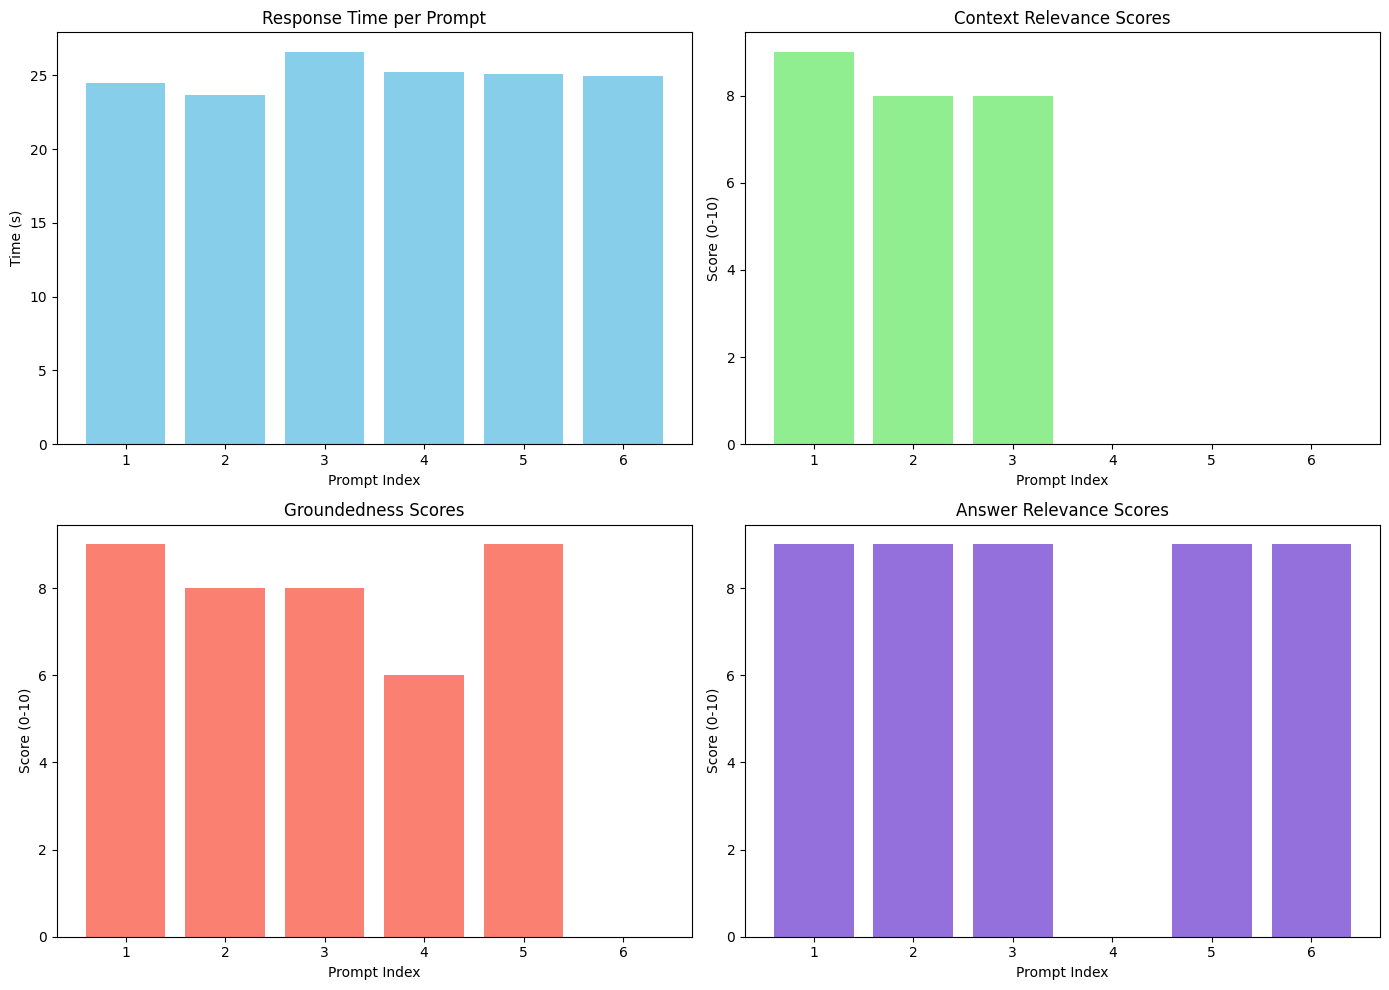

In [20]:
#Plotting the results
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot Response Time
axs[0, 0].bar(range(len(prompts)), times, color='skyblue')
axs[0, 0].set_title('Response Time per Prompt')
axs[0, 0].set_xlabel('Prompt Index')
axs[0, 0].set_ylabel('Time (s)')
axs[0, 0].set_xticks(range(len(prompts)))
axs[0, 0].set_xticklabels(range(1, len(prompts) + 1))

# Plot Context Relevance Scores
axs[0, 1].bar(range(len(prompts)), context_relevance_scores, color='lightgreen')
axs[0, 1].set_title('Context Relevance Scores')
axs[0, 1].set_xlabel('Prompt Index')
axs[0, 1].set_ylabel('Score (0-10)')
axs[0, 1].set_xticks(range(len(prompts)))
axs[0, 1].set_xticklabels(range(1, len(prompts) + 1))

# Plot Groundedness Scores
axs[1, 0].bar(range(len(prompts)), groundedness_scores, color='salmon')
axs[1, 0].set_title('Groundedness Scores')
axs[1, 0].set_xlabel('Prompt Index')
axs[1, 0].set_ylabel('Score (0-10)')
axs[1, 0].set_xticks(range(len(prompts)))
axs[1, 0].set_xticklabels(range(1, len(prompts) + 1))

# Plot Answer Relevance Scores
axs[1, 1].bar(range(len(prompts)), answer_relevance_scores, color='mediumpurple')
axs[1, 1].set_title('Answer Relevance Scores')
axs[1, 1].set_xlabel('Prompt Index')
axs[1, 1].set_ylabel('Score (0-10)')
axs[1, 1].set_xticks(range(len(prompts)))
axs[1, 1].set_xticklabels(range(1, len(prompts) + 1))

plt.tight_layout()
plt.show()

In [21]:
prompts = [
    "Who has sold more cars this year, Zapata (Suc. Pachuca) or Zapata (Suc. Aeropuerto)",
    "Which dealer has had the best sales percentage this year?",
    "Compare the sales between the Zapata dealer and ZAPATA (SUC. AEROPUERTO).",
    "What is the most sold vehicle type at the ZAPATA (SUC. AEROPUERTO) dealership?",
    "Generate a sales report for ZAPATA (SUC. AEROPUERTO) dealership"
]
expected_answers = [
    "Zapata (Suc. Pachuca)",
    "Zapata (Suc. Pachuca)",
    "The Zapata dealership outperformed ZAPATA (SUC. AEROPUERTO), demonstrating significantly higher sales performance overall.",
    "The most sold vehicle type at the ZAPATA (SUC. AEROPUERTO) dealership in 2024 was TRUCKS, with a total of 892 units sold.",
    "The ZAPATA (SUC. AEROPUERTO) dealership's most sold line in 2024 was the TERRITORY with 220 units, showcasing strong performance across outfitter and truck categories."
]

In [22]:
answers = []
times = []
context_relevance_scores = []
groundedness_scores = []
answer_relevance_scores = []

# Process the prompts
for i, query in enumerate(prompts):
    start = time.time()
    qa_chain = RetrievalQA.from_chain_type(llm, retriever=retriever, return_source_documents=True)
    res = qa_chain(query)
    answer, docs = res['result'], res['source_documents']
    end = time.time()

    print(answer)

    # Use regex to extract the first sentence from the result
    first_sentence = re.split(r'\.\s', answer, 1)[0].strip()
    first_sentence = answer

    print(f"\n> Prompt: {query}")
    print(f"> Expected Answer: {expected_answers[i]}")
    print(f"> Model Answer: {first_sentence}") # Print the model's answer and query response time

    context = " ".join([doc.page_content for doc in docs])
    print(f"\n> Context: {context}")
    context_relevance = evaluate_context_relevance(query, context)
    groundedness = evaluate_groundedness(context, answer)
    answer_relevance = evaluate_answer_relevance(query, answer)

    context_relevance_scores.append(context_relevance)
    groundedness_scores.append(groundedness)
    answer_relevance_scores.append(answer_relevance)
    answers.append(answer)
    times.append(round(end - start, 2))

    # Output the result
    print(f"> Context Relevance: {context_relevance}")
    print(f"> Groundedness: {groundedness}")
    print(f"> Answer Relevance: {answer_relevance}")

# Calculate and display the model's performance
average_time = sum(times) / len(times)
average_context_relevance = sum(context_relevance_scores) / len(context_relevance_scores)
average_groundedness = sum(groundedness_scores) / len(groundedness_scores)
average_answer_relevance = sum(answer_relevance_scores) / len(answer_relevance_scores)

print(f"\n\nModel Performance:")
print(f"Average Response Time: {average_time} s")
print(f"Average Context Relevance: {average_context_relevance} / 10")
print(f"Average Groundedness: {average_groundedness} / 10")
print(f"Average Answer Relevance: {average_answer_relevance} / 10")

 It is not possible to determine who has sold more cars this year based on the given context. The information provided only includes the number of vehicles sold by each dealership for the month of March and April, but does not provide any information about the total number of vehicles sold by each dealership throughout the year.

> Prompt: Who has sold more cars this year, Zapata (Suc. Pachuca) or Zapata (Suc. Aeropuerto)
> Expected Answer: Zapata (Suc. Pachuca)
> Model Answer:  It is not possible to determine who has sold more cars this year based on the given context. The information provided only includes the number of vehicles sold by each dealership for the month of March and April, but does not provide any information about the total number of vehicles sold by each dealership throughout the year.

> Context: Dealer Name: Zapata (Suc. Pachuca)
Brand: FORD
Period: 202401
Time Period: MTD
Vehicle Line: MUSTANG
Vehicle Type: CARS
Vehicles Sales Total: 11 Dealer Name: Zapata (Suc. Aer

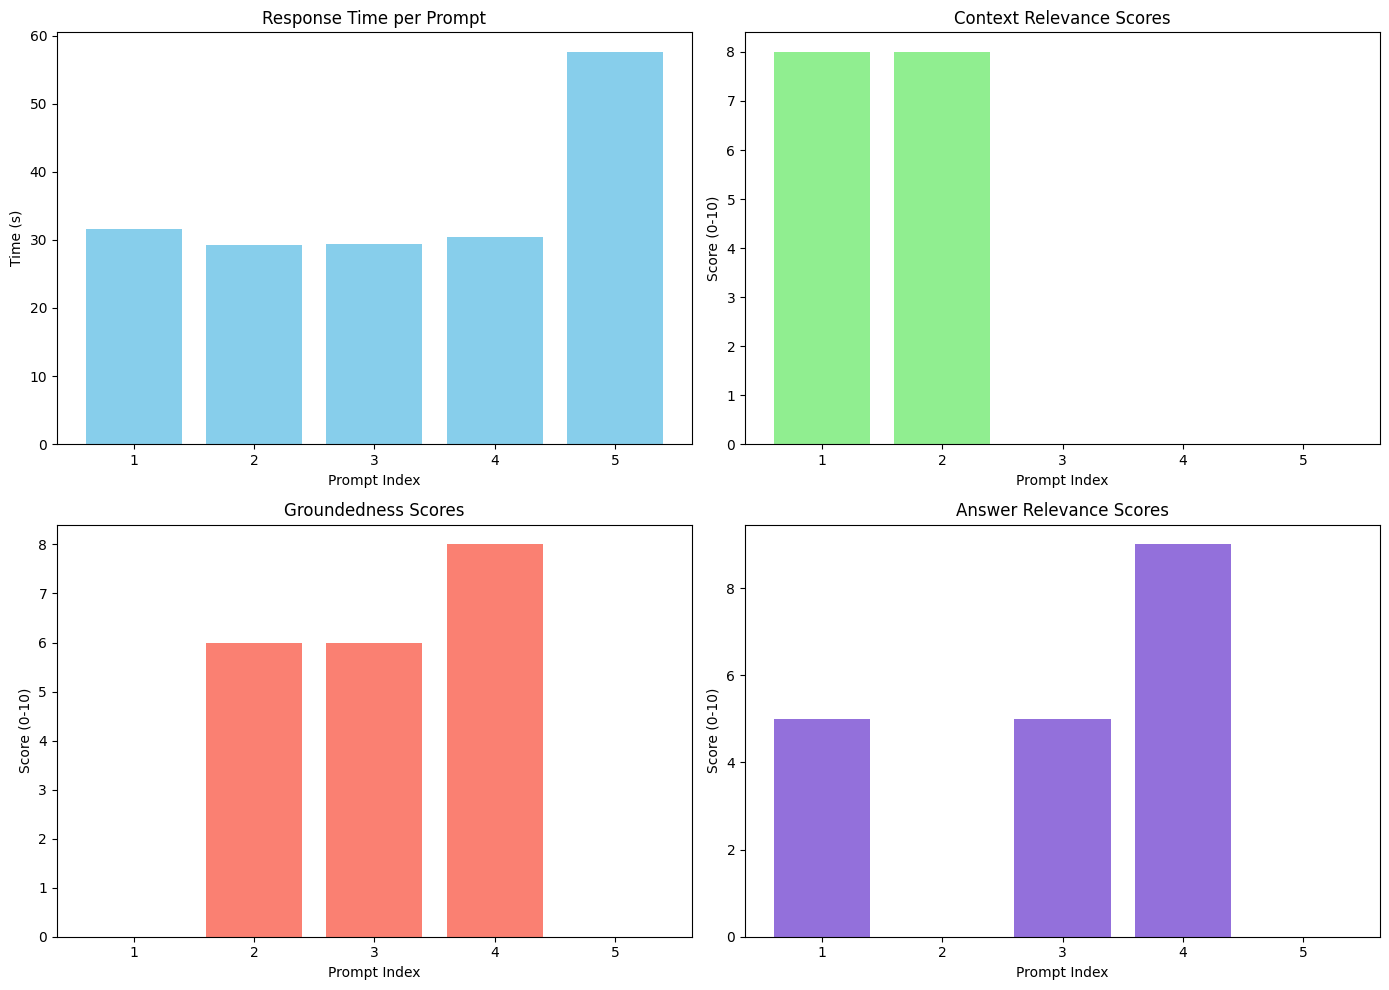

In [23]:
#Plotting the results
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot Response Time
axs[0, 0].bar(range(len(prompts)), times, color='skyblue')
axs[0, 0].set_title('Response Time per Prompt')
axs[0, 0].set_xlabel('Prompt Index')
axs[0, 0].set_ylabel('Time (s)')
axs[0, 0].set_xticks(range(len(prompts)))
axs[0, 0].set_xticklabels(range(1, len(prompts) + 1))

# Plot Context Relevance Scores
axs[0, 1].bar(range(len(prompts)), context_relevance_scores, color='lightgreen')
axs[0, 1].set_title('Context Relevance Scores')
axs[0, 1].set_xlabel('Prompt Index')
axs[0, 1].set_ylabel('Score (0-10)')
axs[0, 1].set_xticks(range(len(prompts)))
axs[0, 1].set_xticklabels(range(1, len(prompts) + 1))

# Plot Groundedness Scores
axs[1, 0].bar(range(len(prompts)), groundedness_scores, color='salmon')
axs[1, 0].set_title('Groundedness Scores')
axs[1, 0].set_xlabel('Prompt Index')
axs[1, 0].set_ylabel('Score (0-10)')
axs[1, 0].set_xticks(range(len(prompts)))
axs[1, 0].set_xticklabels(range(1, len(prompts) + 1))

# Plot Answer Relevance Scores
axs[1, 1].bar(range(len(prompts)), answer_relevance_scores, color='mediumpurple')
axs[1, 1].set_title('Answer Relevance Scores')
axs[1, 1].set_xlabel('Prompt Index')
axs[1, 1].set_ylabel('Score (0-10)')
axs[1, 1].set_xticks(range(len(prompts)))
axs[1, 1].set_xticklabels(range(1, len(prompts) + 1))

plt.tight_layout()
plt.show()